In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Q1. Read the data for January. How many columns are there?

Answer: 19

In [2]:
data_january = pd.read_parquet('data/yellow_tripdata_2023-01.parquet')
print(f"January data: {data_january.shape=}")

data_january.head()

January data: data_january.shape=(3066766, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


Q2. What's the standard deviation of the trips duration in January?

Answer: 42.59 min 

In [3]:
def calculate_duration_min(df):
    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']) \
                    / np.timedelta64(1, 'm')
    
    return df

In [4]:
data_january = calculate_duration_min(data_january)

print(f"Mean duration: {np.mean(data_january['duration']):.2f} min, std: {np.std(data_january['duration']):.2f} min")

Mean duration: 15.67 min, std: 42.59 min


Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

Q3. What fraction of the records left after you dropped the outliers?

Answer: 98%

In [5]:
def remove_duration_outliers(df):
    return df[(df['duration'] >= 1) & (df['duration'] <= 60)]

In [6]:
filtered_data = remove_duration_outliers(data_january)

print(f"The fraction of data left after droping outliers: {filtered_data.shape[0] / data_january.shape[0] * 100:.2f}")

The fraction of data left after droping outliers: 98.12


In [7]:
data_january['duration'].describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [8]:
filtered_data['duration'].describe()

count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: duration, dtype: float64

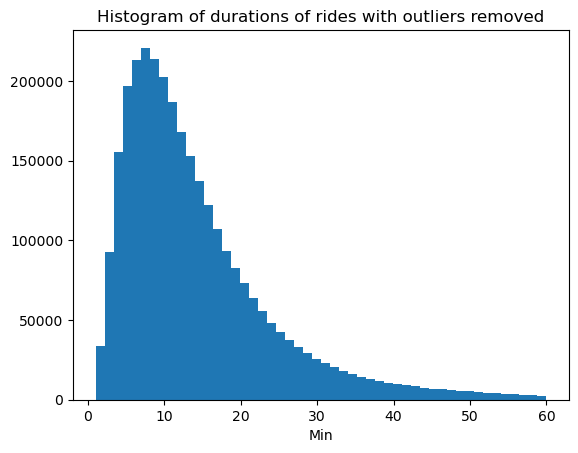

In [9]:
plt.title("Histogram of durations of rides with outliers removed")
plt.hist(filtered_data['duration'], bins=50)
plt.xlabel("Min")
plt.show()

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it


In [10]:
filtered_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [11]:
filtered_data.PULocationID = filtered_data.PULocationID.astype(str)
filtered_data.DOLocationID = filtered_data.DOLocationID.astype(str)

In [12]:
train_dicts = filtered_data[['PULocationID', 'DOLocationID']].to_dict(orient='records')

In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

Q4. What's the dimensionality of this matrix (number of columns)?

Answer: 515

In [14]:
X_train

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

In [15]:
target = 'duration'
y_train = filtered_data[target].values

y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters
- Calculate the RMSE of the model on the training data

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f'Baseline Linear Regression model RMSE: {rmse:0.2f}')

Baseline Linear Regression model RMSE: 7.65


Q5. What's the RMSE on train?

Answer: 7.65

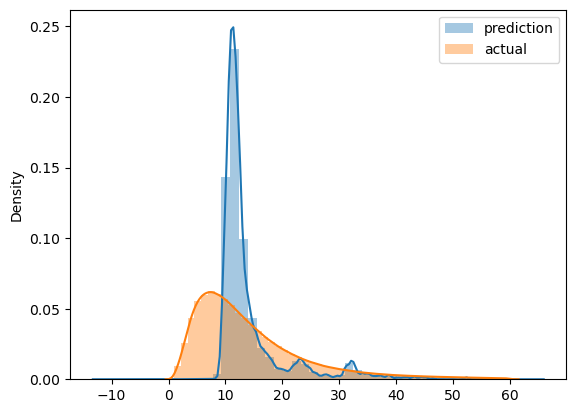

In [17]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

Now let's apply this model to the validation dataset (February 2023).

In [18]:
data_february = pd.read_parquet('data/yellow_tripdata_2023-02.parquet')
print(f"February data: {data_february.shape=}")

data_february.head()

February data: data_february.shape=(2913955, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.0,0.0,1.0,9.40,2.5,0.00
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.0,-1.00,-0.5,0.0,0.0,-1.0,-5.50,0.0,0.00
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.0,1.00,0.5,0.0,0.0,1.0,5.50,0.0,0.00
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.0,0.0,1.0,74.65,0.0,1.25
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.3,0.0,1.0,25.30,2.5,0.00


In [19]:
data_february = calculate_duration_min(data_february)

print(f"Mean duration: {np.mean(data_february['duration']):.2f} min, std: {np.std(data_february['duration']):.2f} min")

Mean duration: 16.02 min, std: 42.84 min


In [20]:
filtered_data = remove_duration_outliers(data_february)

print(f"The fraction of data left after droping outliers: {filtered_data.shape[0] / data_february.shape[0] * 100:.2f}")

The fraction of data left after droping outliers: 98.01


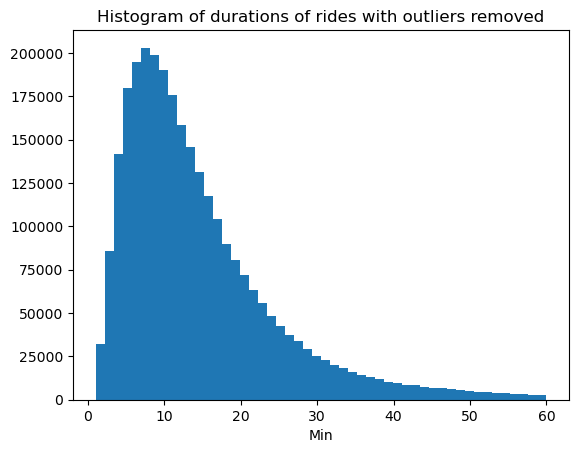

In [21]:
plt.title("Histogram of durations of rides with outliers removed")
plt.hist(filtered_data['duration'], bins=50)
plt.xlabel("Min")
plt.show()

In [22]:
filtered_data.PULocationID = filtered_data.PULocationID.astype(str)
filtered_data.DOLocationID = filtered_data.DOLocationID.astype(str)

In [23]:
val_dicts = filtered_data[['PULocationID', 'DOLocationID']].to_dict(orient='records')

In [24]:
X_val = dv.transform(val_dicts)
y_val = filtered_data[target].values

Q6. What's the RMSE on validation?

Answer: 7.81

In [25]:
y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'Validation baseline Linear Regression model RMSE: {rmse:0.2f}')

Validation baseline Linear Regression model RMSE: 7.81


Validation Root Mean Squared Error is simillar to train RMSE, so the linear regression model didn't overfit.